In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import lfilter # CORRECTED LINE: 'hamming' removed from this import
from IPython.display import Audio, display
import math


In [ ]:
# --- Setup: Vowel Formant Reference Table (from your image) ---
# This dictionary holds the average F1 and F2 values for comparison.
VOWEL_FORMANTS = {
    'i': (240, 2400), 'y': (235, 2100), 'e': (390, 2300), 'ø': (370, 1900),
    'ɛ': (610, 1900), 'œ': (585, 1710), 'a': (850, 1610), 'ɶ': (820, 1530),
    'ɑ': (750, 940),  'ɒ': (700, 760),  'ʌ': (600, 1170), 'ɔ': (500, 700),
    'ɤ': (460, 1310), 'o': (360, 640),  'ɯ': (300, 1390), 'u': (250, 595),
}

In [ ]:
def find_closest_vowel(f1, f2, vowel_chart):
    """Finds the closest vowel in the chart using Euclidean distance."""
    min_dist = float('inf')
    closest_vowel = None
    for vowel, (ref_f1, ref_f2) in vowel_chart.items():
        dist = math.sqrt((f1 - ref_f1)**2 + (f2 - ref_f2)**2)
        if dist < min_dist:
            min_dist = dist
            closest_vowel = vowel
    return closest_vowel

In [ ]:
pip install librosa

In [ ]:
# --- Task 1: Speech Signal Acquisition ---
# For best results, use a recording of a single, sustained vowel.
filepath = '/content/exam-1.wav'
try:
    y, sr = librosa.load(filepath, sr=8000)
except FileNotFoundError:
    print(f"Error: The file '{filepath}' was not found.")
    print("Please save your audio file in the correct directory.")
    exit()

print("--- Original Audio ---")
display(Audio(y, rate=sr))

--- Original Audio ---


In [ ]:
# --- Parameters for Analysis ---
frame_len_ms = 30
order = 10
frame_len = int(sr * frame_len_ms / 1000)

# Select a stable frame from the middle of the signal
mid_idx = len(y) // 2
# CORRECTED LINE: Switched to np.hamming()
analysis_frame = y[mid_idx : mid_idx + frame_len] * np.hamming(frame_len)

In [ ]:
# --- Task 2: LPC Analysis ---
a = librosa.lpc(analysis_frame, order=order)

# --- Task 3: Signal Reconstruction ---
residual = lfilter(a, [1], y)
y_recon = lfilter([1], a, residual)

print("\n--- Reconstructed Audio ---")
display(Audio(y_recon, rate=sr))

# --- Task 4: Formant Estimation ---
roots = np.roots(a)
roots = [r for r in roots if np.imag(r) > 0.01]
angles = np.angle(roots)
formants_hz = sorted(angles * (sr / (2 * np.pi)))


--- Reconstructed Audio ---


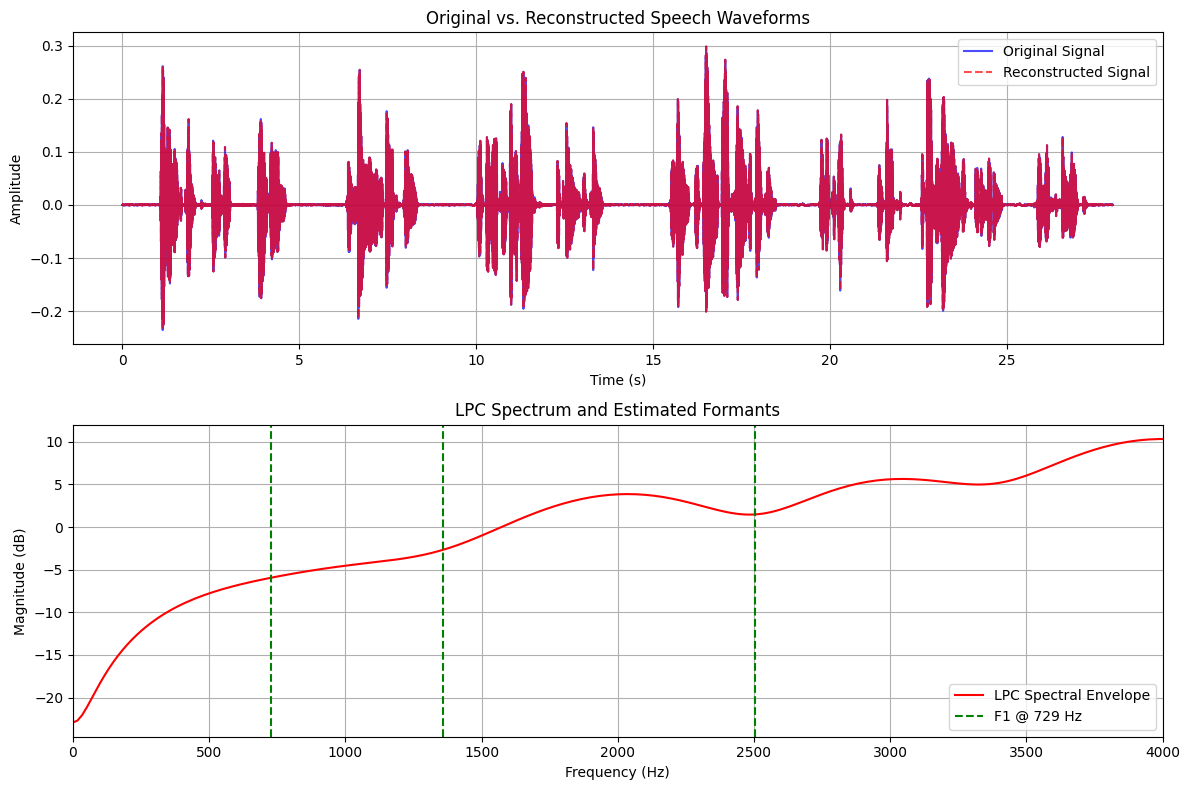


--- 📊 ANALYSIS REPORT ---
Estimated Formants (Hz):
  - F1: 728.64 Hz
  - F2: 1357.44 Hz
  - F3: 2504.22 Hz

Closest Vowel in Reference Table:
  - Predicted Vowel (IPA): 'ɶ'
  - Reference Formants for 'ɶ': F1=820 Hz, F2=1530 Hz


In [ ]:
# --- Task 5: Comparison and Vowel Identification ---
predicted_vowel = "N/A"
if len(formants_hz) >= 2:
    f1_est, f2_est = formants_hz[0], formants_hz[1]
    predicted_vowel = find_closest_vowel(f1_est, f2_est, VOWEL_FORMANTS)
else:
    f1_est, f2_est = (0, 0)
    print("Warning: Could not detect at least two formants.")

# --- Task 6: Visualization ---
# Plot 1: Original vs. Reconstructed Waveforms
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(y))/sr, y, label='Original Signal', color='blue', alpha=0.7)
plt.plot(np.arange(len(y_recon))/sr, y_recon, label='Reconstructed Signal', color='red', linestyle='--', alpha=0.7)
plt.title('Original vs. Reconstructed Speech Waveforms')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.legend(); plt.grid(True)

# Plot 2: Formant Visualization on LPC Spectrum
# Plot 2: Formant Visualization on LPC Spectrum
# Calculate frequency axis for a real FFT
w = np.fft.rfftfreq(n=frame_len*2, d=1./sr)
# Calculate spectrum using the REAL FFT to match the size of w
h = np.fft.rfft(a, n=frame_len*2)
lpc_spectrum = -20 * np.log10(np.abs(1/h))

plt.subplot(2, 1, 2)
# Plot w directly, as it already contains the correct frequencies in Hz
plt.plot(w, lpc_spectrum, 'r', label='LPC Spectral Envelope')
plt.title('LPC Spectrum and Estimated Formants')
for i, f in enumerate(formants_hz[:3]): # Plot first 3 formants
    plt.axvline(x=f, color='g', linestyle='--', label=f'F{i+1} @ {f:.0f} Hz' if i == 0 else f'_nolegend_')
plt.xlabel('Frequency (Hz)'); plt.ylabel('Magnitude (dB)')
plt.legend(); plt.grid(True); plt.xlim(0, sr / 2)
plt.tight_layout()
plt.show()

# --- Final Report ---
print("\n--- 📊 ANALYSIS REPORT ---")
print(f"Estimated Formants (Hz):")
print(f"  - F1: {f1_est:.2f} Hz")
print(f"  - F2: {f2_est:.2f} Hz")
if len(formants_hz) > 2:
    print(f"  - F3: {formants_hz[2]:.2f} Hz")

print(f"\nClosest Vowel in Reference Table:")
print(f"  - Predicted Vowel (IPA): '{predicted_vowel}'")
ref_f1, ref_f2 = VOWEL_FORMANTS.get(predicted_vowel, (0,0))
print(f"  - Reference Formants for '{predicted_vowel}': F1={ref_f1} Hz, F2={ref_f2} Hz")